# Dependencies 

In [1]:
import sys
sys.path.append('../src/')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
from glob import glob
from itertools import product
from mrk_file import MRKFile
from utils import load
from global_config import FOLDER_IMAGES, FOLDER_MRKS

%matplotlib inline

pd.options.display.max_columns = None

In [2]:
print(FOLDER_IMAGES)
print(FOLDER_MRKS)

../data/pybossa/images/
../data/pybossa/ground_truth/1_3_6/


# Helper Functions

In [3]:
def requirements_statistics_from_dataset(list_mrk_files):
    reqs_comp, reqs_non_comp, reqs_dummy = [], [], []
    req_names = [req.description for req in list_mrk_files[0].photo_reqs]
    
    for mrk_file in list_mrk_files:
        reqs_comp.append([req.is_compliant() for req in mrk_file.photo_reqs])
        reqs_non_comp.append([req.is_non_compliant() for req in mrk_file.photo_reqs])
        reqs_dummy.append([req.is_dummy() for req in mrk_file.photo_reqs])
        
    counts_comp = np.array(reqs_comp).sum(axis=0)
    counts_non_comp = np.array(reqs_non_comp).sum(axis=0)
    counts_dummy = np.array(reqs_dummy).sum(axis=0)

    df_stats = pd.DataFrame(np.vstack((counts_comp, counts_non_comp, counts_dummy)).T, 
                            index=req_names, 
                            columns=['C', 'NC', 'D'])
    return df_stats

def plot_requirements_statistics(df_stats):
    ax = df_stats.plot(kind='barh', stacked=True, figsize=(10, 8))
    ax.invert_yaxis()
    
def plot_labels_by_sample(list_mrk_files):
    values = np.array([mrk.photo_reqs.values() for mrk in list_mrk_files])

    compliants_by_sample = (values == 1).sum(axis=1)
    non_compliants_by_sample = (values == 0).sum(axis=1)
    
    _, counts_c = np.unique(compliants_by_sample, return_counts=True)
    _, counts_nc = np.unique(non_compliants_by_sample, return_counts=True)
    
    plt.figure(figsize=(20, 8))
    plt.plot(range(counts_c.size), counts_c, marker='o', label='Compliant')
    plt.plot(range(counts_nc.size), counts_nc, marker='o', label='Non-compliant')
    plt.legend()
    plt.show()
    
def requirements_correlation(list_mrk_files, norm_col=None, lower_only=False, cond=lambda a, b: a.is_non_compliant() and b.is_dummy()):
    n_reqs = 23
    corr_matrix = np.zeros((n_reqs, n_reqs), dtype=np.uint32)
    for i, mrk_file in enumerate(list_mrk_files):
        list_corrs = []
        for req_i, req_j in product(mrk_file.photo_reqs, repeat=2):
            list_corrs.append(cond(req_i, req_j))
        corr_matrix += np.array(list_corrs).reshape(corr_matrix.shape)
    
    plt.figure(figsize=(10, 10))
    labels = ['{} [{}]'.format(name, i) for i, name in enumerate(req_names)]

    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    if lower_only:
        mask[np.triu_indices_from(mask, k=1)] = True
        mask[corr_matrix == 0] = True
    else:
        mask = corr_matrix == 0
        
    norm_corr = corr_matrix if norm_col is None else corr_matrix / (norm_col + 1e-8)
    sns.heatmap(norm_corr, cmap=plt.cm.Blues, annot=corr_matrix, fmt='d', cbar=False, mask=mask, yticklabels=labels)

# Data Loading

In [4]:
mrk_files = load.mrk_files_from_folder(FOLDER_MRKS)

5763 of 5763


In [5]:
req_names = [req.description for req in mrk_files[0].photo_reqs]
n_reqs = len(req_names)

print(n_reqs)
print('\n'.join(req_names))

23
Blurred
Looking away
Ink marked/creased
Unnatural skin tone
Too dark/light
Washed out
Pixelation
Hair across eyes
Eyes closed
Varied background
Roll/pitch/yaw rotations greater than a predefined thresholds
Flash reflection on skin
Red eyes
Shadows behind head
Shadows across face
Dark tinted lenses
Flash reflection on lenses
Frames too heavy
Frame covering eyes
Hat/cap
Veil over face
Mouth open
Presence of other faces or toys too close to face


# Data Analysis

## Labels per Sample 

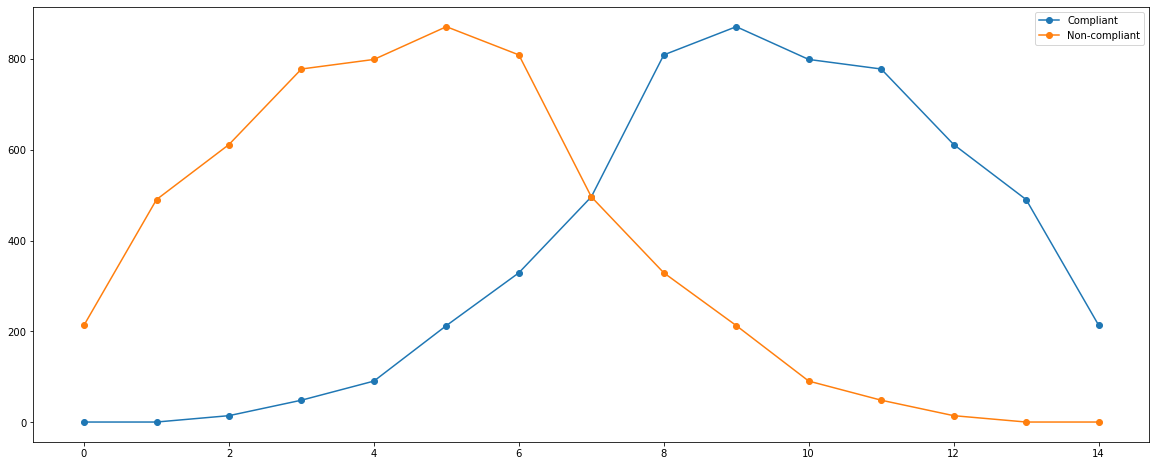

In [6]:
plot_labels_by_sample(mrk_files)

## Requirements per Dataset 

,C,NC,D
Blurred,4916,847,0
Looking away,3898,1865,0
Ink marked/creased,5763,0,0
Unnatural skin tone,2565,3198,0
Too dark/light,5179,584,0
Washed out,5716,47,0
Pixelation,5371,392,0
Hair across eyes,5096,667,0
Eyes closed,4562,1201,0
Varied background,3212,2551,0


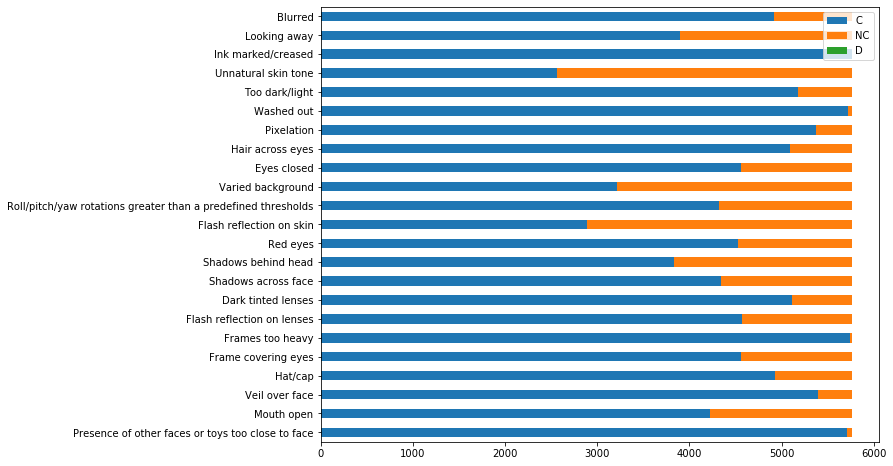

In [7]:
df = requirements_statistics_from_dataset(mrk_files)
plot_requirements_statistics(df)
df

## Proportion of Requirements per Dataset

In [8]:
df_prop = df.div(df.sum(axis=1), axis=0)
df_prop * 100

,C,NC,D
Blurred,85.302794,14.697206,0.0
Looking away,67.638383,32.361617,0.0
Ink marked/creased,100.000000,0.000000,0.0
Unnatural skin tone,44.508069,55.491931,0.0
Too dark/light,89.866389,10.133611,0.0
Washed out,99.184453,0.815547,0.0
Pixelation,93.197987,6.802013,0.0
Hair across eyes,88.426167,11.573833,0.0
Eyes closed,79.160160,20.839840,0.0
Varied background,55.734860,44.265140,0.0


## Non-compliant requirements

In [9]:
df_nc = pd.DataFrame(df.NC, columns=['NC'])
df_nc

,NC
Blurred,847
Looking away,1865
Ink marked/creased,0
Unnatural skin tone,3198
Too dark/light,584
Washed out,47
Pixelation,392
Hair across eyes,667
Eyes closed,1201
Varied background,2551


## Correlation between Requirements 

### Non-compliant Requirements

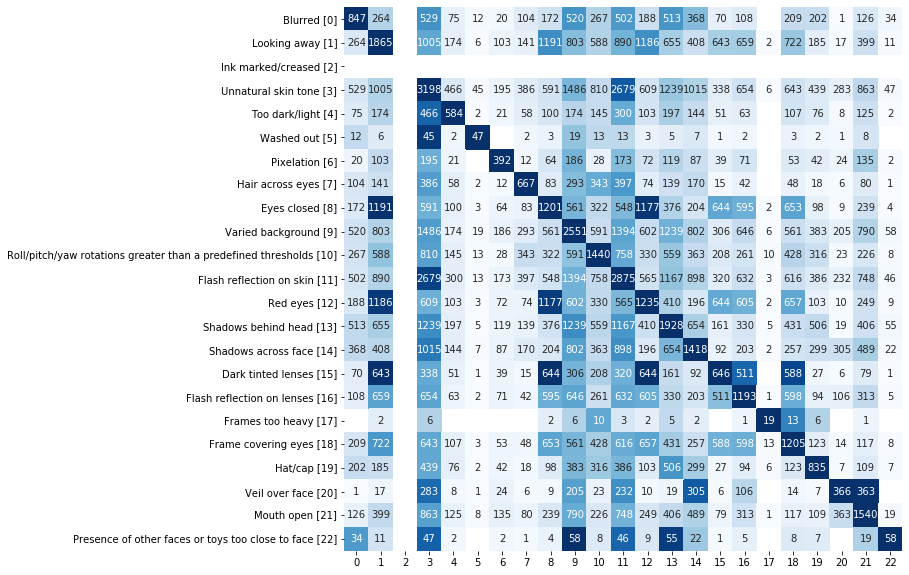

In [10]:
requirements_correlation(mrk_files, norm_col=df.NC.values.reshape(-1, 1), cond=lambda a, b: a.is_non_compliant() and b.is_non_compliant())